In [1]:
%pylab inline
import cv2
import imutils
from imutils import contours
import matplotlib.patches as patches
import pytesseract

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load the input image, resize it, and convert it to grayscale
image = cv2.imread("haar_classifier/new_supermarket_photos/spar_results/ok/44.jpg")
image = imutils.resize(image, width=300)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

/home/redhog/Projects/innovationgarage/price-tag-reader/env/local/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


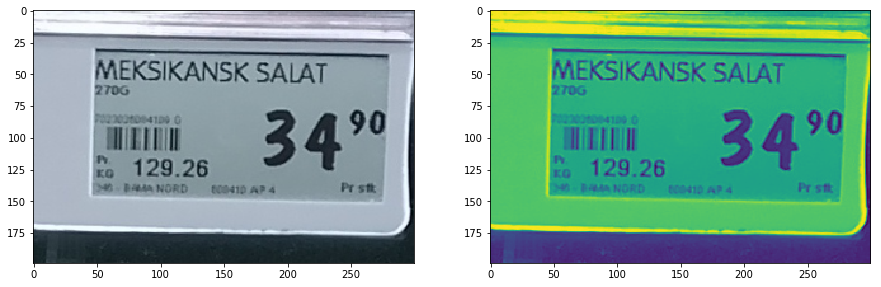

In [3]:
fig = plt.figure()
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs = axs.flatten()
axs[0].imshow(image)
axs[1].imshow(gray)
fig.show()

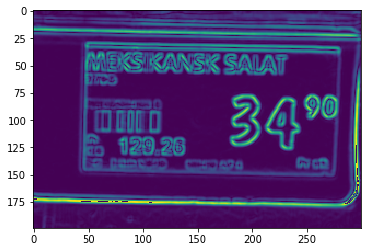

In [4]:
grads = []
for dx, dy in ((1, 0), (0, 1)):
    grad = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=dx, dy=dy,ksize=9)
    grad = np.absolute(grad)
    (minVal, maxVal) = (np.min(grad), np.max(grad))
    grad = (255 * ((grad - minVal) / (maxVal - minVal)))
    grad = grad.astype("uint8")
    #grad = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    grads.append(grad)

grad = grads[0] + grads[1]
plt.imshow(grad)
plt.show()

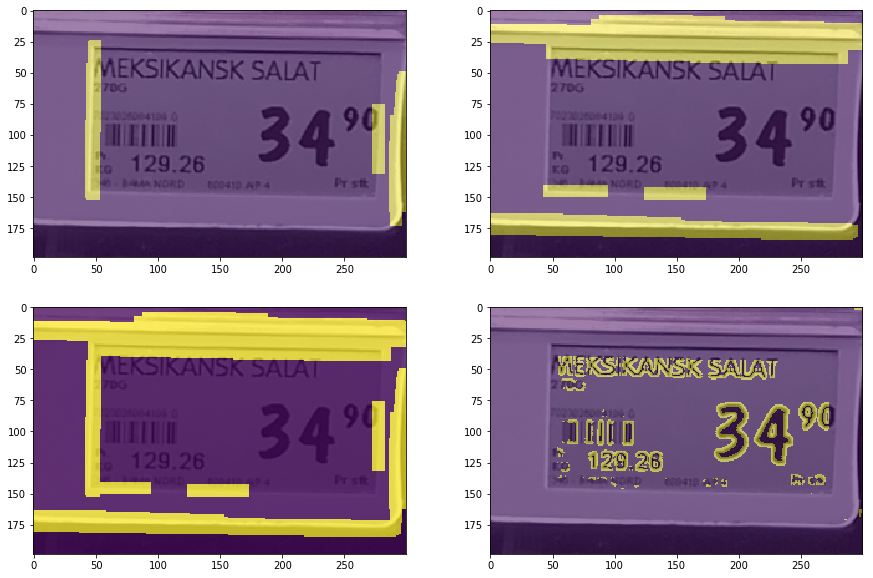

In [5]:
fig = plt.figure()
fig, axs = plt.subplots(2,2, figsize=(15,10))
axs = axs.flatten()

rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
lines = [None, None]
for idx, (ax, kern) in enumerate(zip(axs, (cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40)),
                                           cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))))):
    lines[idx] = cv2.erode(grad, kern)
    lines[idx] = cv2.threshold(lines[idx], 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    lines[idx] = cv2.dilate(lines[idx], rectKern)
    lines[idx] = cv2.dilate(lines[idx], kern)

    ax.imshow(image, alpha=1)
    ax.imshow(lines[idx], alpha=0.5)

lines = lines[0] + lines[1]
objgrads = cv2.threshold(cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] - lines, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

axs[2].imshow(image, alpha=1)
axs[2].imshow(lines, alpha=0.5)
axs[2].imshow(lines, alpha=0.5)
axs[3].imshow(image, alpha=1)
axs[3].imshow(objgrads, alpha=0.5)

fig.show()

In [6]:
cnts = cv2.findContours(objgrads.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]

rects = [cv2.boundingRect(c) for c in cnts]

In [7]:
def boxDist(r1, r2):
    """Distance from center of right edge of r1 to center of left edge of r2 divided by their (max) height."""
    return sqrt((r1[0] + r1[2] - r2[0])**2 + 
                (r1[1] + r1[3] / 2. - (r2[1] + r2[3] / 2.))**2) / float(max(r1[3], r2[3]))

def boxDiff(r1, r2):
    """'Unsigned' height ratio between boxes"""
    if r1[3] < r2[3]:
        return r1[3] / float(r2[3])
    else:
        return r2[3] / float(r1[3])

lines = []
for ridx, r in sorted(enumerate(rects), lambda a, b: cmp(a[1][0], b[1][0])):
    boxdists = sorted(((boxDist(rects[l[-1]], r),
                        boxDiff(rects[l[-1]], r),
                        lidx)
                       for lidx, l in enumerate(lines)),
                      lambda a, b: cmp(a[0], b[0]))
    boxdists = [(dist, diff, lidx)
                for (dist, diff, lidx) in boxdists
                if dist < 1 and diff > 0.75]
    if boxdists:
        dist, diff, lidx = boxdists[0]
        #print "%s added to %s after %s with distance %s and diff %s" % (ridx, lidx, lines[lidx][-1], dist, diff)
        lines[lidx].append(ridx)
    else:
        #print "%s added to new line %s" % (ridx, len(lines))
        lines.append([ridx])

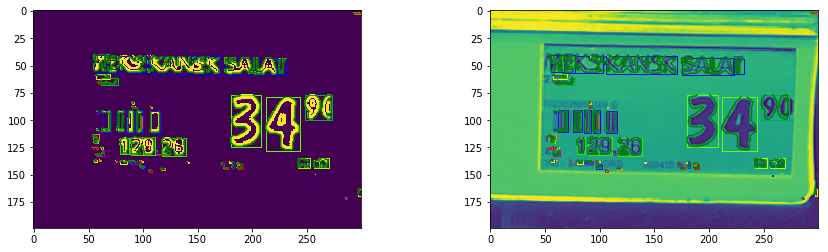

In [8]:
def drawLines(ax):
    cmap = plt.get_cmap("prism")
    for idx, l in enumerate(lines):
        color = cmap(idx / float(len(lines)))
        for bidx in l:
            b = rects[bidx]
            ax.add_patch(patches.Rectangle((b[0],b[1]),b[2],b[3], fill=False, edgecolor=color))

def drawCountours(ax):
    for c in cnts:
        ax.plot(c[:,0,0], c[:,0,1], color="green")

fig, axs = plt.subplots(1,2, figsize=(15,4))
axs = axs.flatten()
axs[0].imshow(objgrads)
axs[1].imshow(gray)
for idx in (0, 1):
    drawCountours(axs[idx])
    drawLines(axs[idx])


    fig.show()

In [9]:
def bbox2pos(b):
    b = list(b)
    b[2] += b[0]
    b[3] += b[1]
    return b

def pos2bbox(p):
    p = list(p)
    p[2] -= p[0]
    p[3] -= p[1]
    return tuple(p)

lineboxes = []
for line in lines:
    pos = bbox2pos(rects[line[0]])
    for bidx in line[1:]:
        p = bbox2pos(rects[bidx])
        if p[0] < pos[0]:
            pos[0] = p[0]
        if p[1] < pos[1]:
            pos[1] = p[1]
        if p[2] > pos[2]:
            pos[2] = p[2]
        if p[3] > pos[0]:
            pos[3] = p[3]
    lineboxes.append(pos2bbox(pos))

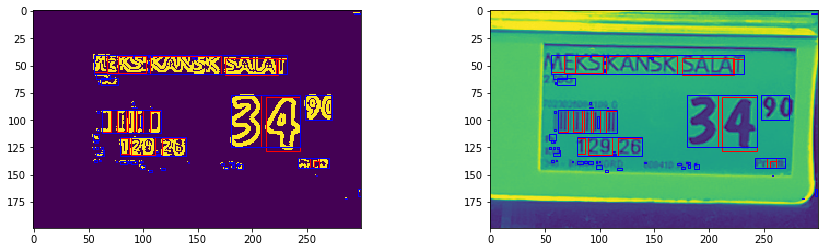

In [10]:
def drawLineParts(ax):
    for idx, l in enumerate(lines):
        for bidx in l:
            b = rects[bidx]
            ax.add_patch(patches.Rectangle((b[0],b[1]),b[2],b[3], fill=False, edgecolor="red"))

def drawLineBoxes(ax):
    cmap = plt.get_cmap("prism")
    for b in lineboxes:
        ax.add_patch(patches.Rectangle((b[0],b[1]),b[2],b[3], fill=False, edgecolor="blue"))

fig, axs = plt.subplots(1,2, figsize=(15,4))
axs = axs.flatten()
axs[0].imshow(objgrads)
axs[1].imshow(gray)
for idx in (0, 1):
    drawLineParts(axs[idx])
    drawLineBoxes(axs[idx])
    fig.show()

In [11]:
from PIL import Image
linetexts = []
for b in lineboxes:
    (x, y, w, h) = b
    if w < 10 or h < 10:
        txt = ""
    else:
        x -= 5
        y -= 5
        w += 10
        h += 10
        roi = gray[y:y + h, x:x + w]
        if not roi.shape[0] or not roi.shape[1]:
            txt = ""
        else:
            txt = pytesseract.image_to_string(Image.fromarray(roi))
    linetexts.append(txt)

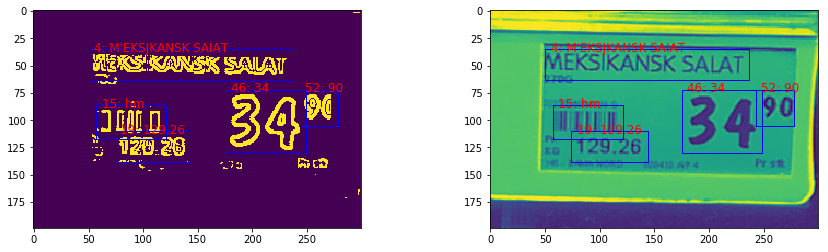

In [12]:
def drawLineBoxesAndText(ax):
    cmap = plt.get_cmap("prism")
    for lidx, (b, txt) in enumerate(zip(lineboxes, linetexts)):
        if not txt: continue
        ax.add_patch(patches.Rectangle((b[0]-5,b[1]-5),b[2]+10,b[3]+10, fill=False, edgecolor="blue"))
        ax.text(b[0], b[1], "%s: %s" % (lidx, txt),
                horizontalalignment='left',
                verticalalignment='bottom',
                fontsize=12,
                color="red")
        
fig, axs = plt.subplots(1,2, figsize=(15,4))
axs = axs.flatten()
axs[0].imshow(objgrads)
axs[1].imshow(gray)
for idx in (0, 1):
    drawLineBoxesAndText(axs[idx])
    fig.show()

In [13]:
def cut_image(img, bbox, vmargin=0, hmargin=0):
    (x, y, w, h) = bbox
    x -= hmargin
    y -= vmargin
    w += 2*hmargin
    h += 2*vmargin
    return img[y:y + h, x:x + w]
    
def is_barcode(img, cutoff=0.2):
    h, w = img.shape
    thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        
    vkern = cv2.getStructuringElement(cv2.MORPH_RECT, (1,int(h/2.)))
    hkern = cv2.getStructuringElement(cv2.MORPH_RECT, (int(w/2.), 1))

    vimg = cv2.erode(thresh, vkern)
    himg = cv2.erode(thresh, hkern)

    vimg = numpy.bitwise_or.reduce(vimg, axis=0)
    himg = numpy.bitwise_or.reduce(himg, axis=1)

    vbarcodiness = vimg.sum() / 255. / len(vimg) > cutoff
    hbarcodiness = himg.sum() / 255. / len(himg) > cutoff
    
    #print "vimg", len(vimg), vimg.sum() / 255., vimg.sum() / 255. / len(vimg)
    #print "himg", len(himg), himg.sum() / 255., himg.sum() / 255. / len(himg)
    
    if (   (vbarcodiness and not hbarcodiness)
        or (not vbarcodiness and hbarcodiness)):
        return True
    else:
        return False

for lidx in xrange(0, len(lineboxes)):
    if lineboxes[lidx][2] > 10 and lineboxes[lidx][3] > 10:
        print lidx, is_barcode(cut_image(grad, lineboxes[lidx], vmargin=5, hmargin=5))


4 False
15 True
19 False
46 False
52 False
